<a href="https://www.kaggle.com/code/mrsalty/titanic-machine-learning-from-disaster?scriptVersionId=119276448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from keras.models import Model, Sequential 
from keras.callbacks import EarlyStopping

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load data

In [2]:
# load data from files
X_train = pd.read_csv("/kaggle/input/titanic/train.csv")
X_submission = pd.read_csv("/kaggle/input/titanic/test.csv")
y_train = X_train['Survived']

# remove y column
X_train = X_train.drop(columns='Survived')

## Data dictionary


|Variable|Definition|Key
|----|----|----
|survival|Survival|0 = No, 1 = Yes
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
|sex|Sex|
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic
|parch|# of parents / children aboard the Titanic
|ticket|Ticket number
|fare|Passenger fare
|cabin|Cabin number
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampto

## Data analysis

In [3]:
X_train.shape

(891, 11)

In [4]:
X_submission.shape

(418, 11)

In [5]:
X_train.head(50)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
X_submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# count of nan values per column
for col in X_train:
    nan_count = X_train[col].isna().sum()
    if nan_count>0:
        print(f'{col}:{nan_count}')

Age:177
Cabin:687
Embarked:2


In [8]:
# count of unique values per column
for col in X_train:
        print(f'{col}:{X_train[col].nunique()}')

PassengerId:891
Pclass:3
Name:891
Sex:2
Age:88
SibSp:7
Parch:7
Ticket:681
Fare:248
Cabin:147
Embarked:3


(array([40., 14., 15., 31., 79., 98., 85., 84., 73., 45., 35., 35., 29.,
        16., 13., 11.,  4.,  5.,  1.,  1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <BarContainer object of 20 artists>)

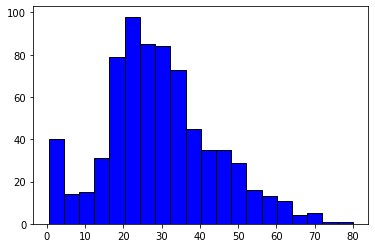

In [9]:
# age  distribution
plt.hist(X_train['Age'], color = 'blue', edgecolor = 'black', bins = 20)

(array([577., 314.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

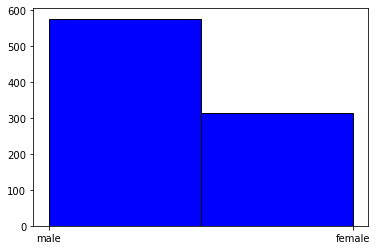

In [10]:
# gender  distribution
plt.hist(X_train['Sex'], color = 'blue', edgecolor = 'black', bins = 2)

(array([216., 184., 491.]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <BarContainer object of 3 artists>)

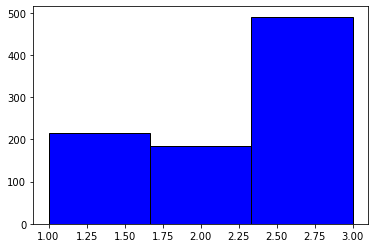

In [11]:
# tikets class  distribution
plt.hist(X_train['Pclass'], color = 'blue', edgecolor = 'black', bins = 3)

(array([496., 191.,  45.,  45.,  48.,  13.,  11.,  11.,   9.,   2.,   0.,
          0.,   5.,   4.,   2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
        102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
        204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
        307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
        409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
        512.3292 ]),
 <BarContainer object of 30 artists>)

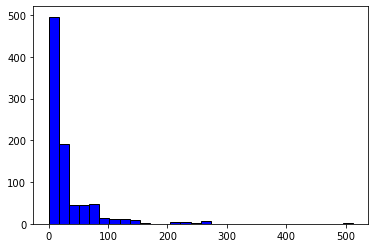

In [12]:
# tikets class  distribution
plt.hist(X_train['Fare'], color = 'blue', edgecolor = 'black', bins = 30)

## Preprocessing 

### Fill nan with 0

In [13]:
X_train["Age"] = X_train["Age"].fillna(0)
X_submission["Age"] = X_submission["Age"].fillna(0)

X_train["Cabin"] = X_train["Cabin"].fillna(0)
X_submission["Cabin"] = X_submission["Cabin"].fillna(0)

X_train["Embarked"] = X_train["Embarked"].fillna(0)
X_submission["Embarked"] = X_submission["Embarked"].fillna(0)

remove column not relevant for training

In [14]:
# to use later for submission
X_submission_passengerId = X_submission['PassengerId']

X_train = X_train.drop(columns='Name')
X_train = X_train.drop(columns='Ticket')
X_train = X_train.drop(columns='PassengerId')
X_train = X_train.drop(columns='Pclass')
X_submission = X_submission.drop(columns='Name')
X_submission = X_submission.drop(columns='Ticket')
X_submission = X_submission.drop(columns='PassengerId')
X_submission = X_submission.drop(columns='Pclass')


In [15]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,male,22.0,1,0,7.2500,0,S
1,female,38.0,1,0,71.2833,C85,C
2,female,26.0,0,0,7.9250,0,S
3,female,35.0,1,0,53.1000,C123,S
4,male,35.0,0,0,8.0500,0,S


ordinal encode categorical features

In [16]:
cols_to_encode = ["Sex","Cabin","Embarked"]

enc = OrdinalEncoder()
for col in cols_to_encode:
    X_train[col] = X_train[col].astype('str')
    X_submission[col] = X_train[col].astype('str') 
    
enc.fit(X_train[cols_to_encode])
enc.categories_
X_train[cols_to_encode] = enc.transform(X_train[cols_to_encode])
X_submission[cols_to_encode] = enc.transform(X_submission[cols_to_encode])
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1.0,22.0,1,0,7.2500,0.0,3.0
1,0.0,38.0,1,0,71.2833,82.0,1.0
2,0.0,26.0,0,0,7.9250,0.0,3.0
3,0.0,35.0,1,0,53.1000,56.0,3.0
4,1.0,35.0,0,0,8.0500,0.0,3.0


discretize age

In [17]:
#kbinsAge = KBinsDiscretizer(n_bins=15, strategy='uniform', encode='ordinal')
#X_train['Age'] = kbinsAge.fit_transform(np.array(X_train['Age']).reshape(-1,1))

#kbinsFare = KBinsDiscretizer(n_bins=30, strategy='uniform', encode='ordinal')
#X_train['Fare'] = kbinsFare.fit_transform(np.array(X_train['Fare']).reshape(-1,1))

#kbinsAgeSubm = KBinsDiscretizer(n_bins=15, strategy='uniform', encode='ordinal')
#X_submission['Age'] = kbinsAgeSubm.fit_transform(np.array(X_submission['Age']).reshape(-1,1))

#kbinsFareSubm = KBinsDiscretizer(n_bins=30, strategy='uniform', encode='ordinal')
#X_submission['Fare'] = kbinsFareSubm.fit_transform(np.array(X_submission['Fare']).reshape(-1,1))

In [18]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1.0,22.0,1,0,7.2500,0.0,3.0
1,0.0,38.0,1,0,71.2833,82.0,1.0
2,0.0,26.0,0,0,7.9250,0.0,3.0
3,0.0,35.0,1,0,53.1000,56.0,3.0
4,1.0,35.0,0,0,8.0500,0.0,3.0


scaling

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_submission = sc.fit_transform(X_submission)

## Split train and test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Train model

In [21]:
input = Input(shape=(7,))
x = Dense(64, activation='relu')(input)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)

2023-02-15 17:01:04.665411: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2, verbose=1)

model.compile(optimizer='adam'
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

In [23]:
NUM_EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(X_train
                    , y_train
                    , epochs=NUM_EPOCHS
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_val, y_val)
                    , verbose=1
                    , callbacks=[early_stopping_callback])


2023-02-15 17:01:04.908311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
9/9 [==============================] - 1s 37ms/step - loss: 0.6485 - accuracy: 0.6854 - val_loss: 0.5874 - val_accuracy: 0.7697
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.5735 - accuracy: 0.7753 - val_loss: 0.5404 - val_accuracy: 0.7640
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.5319 - accuracy: 0.7772 - val_loss: 0.5091 - val_accuracy: 0.7584
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.5031 - accuracy: 0.7846 - val_loss: 0.4897 - val_accuracy: 0.7584
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4837 - accuracy: 0.8071 - val_loss: 0.4807 - val_accuracy: 0.7697
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4640 - accuracy: 0.7846 - val_loss: 0.4766 - val_accuracy: 0.7809
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4594 - accuracy: 0.7996 - val_loss: 0.4778 - val_accuracy: 0.7753
Epoch 8/50
9/9 [=================

In [24]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.show()

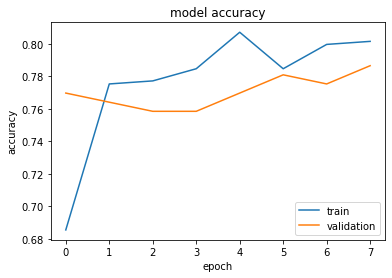

In [25]:
plot_accuracy(history)

In [26]:
X_submission_passengerId.shape

(418,)

In [27]:
y_pred = model.predict(X_submission)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
y_pred = y_pred.ravel().astype(int)
print(y_pred)

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1
 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1
 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1
 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 1 1 1]


In [28]:
final_df = pd.DataFrame({'PassengerId': X_submission_passengerId, 'Survived': y_pred.astype(int).tolist()})
final_df.head(20)

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,1


In [29]:
final_df.to_csv('submission.csv', index=False)
print(" Submission saved")

 Submission saved
